# Проект: Поиск по изображениям

**Заказчик исследования:** Фотохостинг для профессиональных фотографов «Со Смыслом» (“With Sense”). 

**Цель проекта:** разработать демонстрационную версию модели поиска изображений по текстовому запросу.

**Полученные данные:** набор изображений с текстовым сопровождением и оценкой соответствия текста изображениям + набор данных для тестирования модели

**План работы:**

1. Исследовательский анализ данных
2. Проверка данных
3. Векторизация изображений
4. Векторизация текстов
5. Объединение векторов
6. Обучение модели предсказания соответствия
7. Тестирование модели
8. Вывод

In [1]:
import os
import pandas as pd
import numpy as np
import random as rd
np.random.seed(42)
from math import ceil
from pathlib import Path

import matplotlib.pyplot as plt

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import models, transforms

from sklearn.model_selection import GroupShuffleSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
RANDOM_STATE = 42

## Загрузка данных и первичный анализ

In [3]:
df_train = pd.read_csv(r'/kaggle/input/dataset-full/to_upload/train_dataset.csv')
df_test = pd.read_csv(r'/kaggle/input/dataset-full/to_upload/test_queries.csv', sep='|', index_col='Unnamed: 0')
crowd_ann = pd.read_csv(r'/kaggle/input/dataset-full/to_upload/CrowdAnnotations.tsv', sep='\t', names = ['image', 'query_id', 'fraction', 'pros', 'cons'])
expert_ann = pd.read_csv(r'/kaggle/input/dataset-full/to_upload/ExpertAnnotations.tsv', sep='\t', names = ['image', 'query_id', 'first', 'second', 'third'])
test_images = pd.read_csv('/kaggle/input/dataset-full/to_upload/test_images.csv', sep='|')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [5]:
df_train.head(5)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [6]:
len(df_train['image'].unique())

1000

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [8]:
df_test.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [9]:
len(df_test['image'].unique())

100

In [10]:
crowd_ann.info()
print()
print(crowd_ann.describe())
print()
print(crowd_ann.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   fraction  47830 non-null  float64
 3   pros      47830 non-null  int64  
 4   cons      47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB

           fraction          pros          cons
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000

                       image                     query_id  fraction  pros  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7

In [11]:
expert_ann.info()
print()
print(expert_ann.describe())
print()
print(expert_ann.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB

             first       second        third
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

                       image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7

данные загружены. по итогам первичного анализа можно сделать следующие выводы:
1. в данных отсутствуют пропуски.
2. для тренировки модели предоставлено 1000 изображений
3. для тестирования модели предоставлено 100 изображений
4. краудсорсинговая оценка - средняя доля подтвердивших соответствие изображения текстовому описанию составляет всего 7%. среднее количество участников краудсорсинговой оценки - 3 человека
5. экспертная оценка - средняя экспертная оценка не превышает 2

судя по всему мы имеем большой перекос в сторону несоответствия текстов изображениям

## Исследовательский анализ

In [ ]:

samples_train = list(df_train['image'].sample(12))
samples_test = list(df_test['image'].sample(12))

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(6, 4, i+1)
    image = Image.open(Path(r'/kaggle/input/dataset-full/to_upload', 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(12):
    fig.add_subplot(6, 4, i+13)
    image = Image.open(Path(r'/kaggle/input/dataset-full/to_upload', 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

del image


- в датасете представлены изображения разного качества, наклона, пола, типа (фас, профиль и т.д.), тематики
- все изображения цветные
- изображения имеют разные размеры (потребуется приведение к единому формату)

In [ ]:
def result_exp(str_in):
    res=[0,0,0,0]
    for i in range(0,3):
        res[int(str_in[i+2]-1)]+=1
    if max(res) == 1:
        return None
    else:
        try:
            return res.index(max(res))+1
        except:
            print('ERROR')
            return None

In [14]:
expert_ann['expert'] = expert_ann.apply(result_exp, axis=1)

/tmp/ipykernel_82/1995044521.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res[int(str_in[i+2]-1)]+=1


In [15]:
expert_ann.head()

,image,query_id,first,second,third,expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.0


In [16]:
expert_ann = expert_ann.dropna()

In [17]:
expert_ann.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5696 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     5696 non-null   object 
 1   query_id  5696 non-null   object 
 2   first     5696 non-null   int64  
 3   second    5696 non-null   int64  
 4   third     5696 non-null   int64  
 5   expert    5696 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 311.5+ KB


In [18]:
train_data = expert_ann.merge(df_train, left_on=['query_id', 'image'], right_on=['query_id', 'image'], how='inner')
train_data = train_data.drop(['first', 'second', 'third'], axis=1)

In [19]:
train_data.info()
print()
print(train_data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5696 non-null   object 
 1   query_id    5696 non-null   object 
 2   expert      5696 non-null   float64
 3   query_text  5696 non-null   object 
dtypes: float64(1), object(3)
memory usage: 178.1+ KB

                       image                     query_id  expert  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1.0   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     1.0   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1.0   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     2.0   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     1.0   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2     1.0   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2     1.0   
7  1056338697_4f7d7ce270.jpg   434792818_

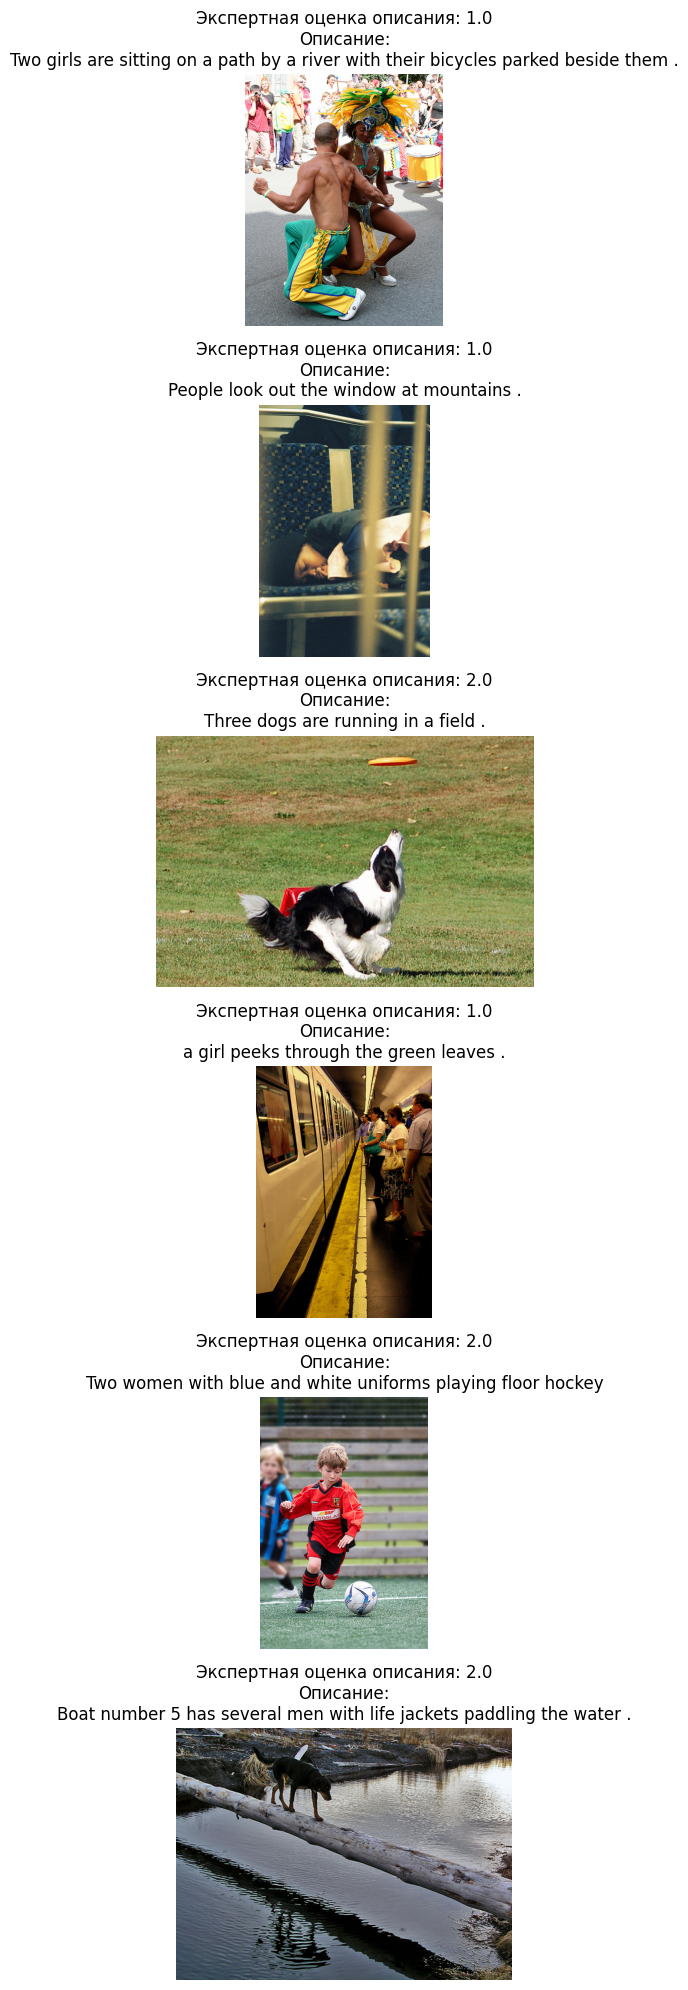

In [20]:
random_images = train_data.sample(6)

fig = plt.figure(figsize=(20,20))

for i, row in enumerate(random_images.itertuples()):
    fig.add_subplot(6, 1, i+1)
    image = Image.open(Path(r'/kaggle/input/dataset-full/to_upload', 'train_images', row.image))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Экспертная оценка описания: {row.expert}\nОписание:\n{row.query_text}")

plt.tight_layout()
plt.show()

del image



для получения агрегированной оценки выбраны оценки экспертов.
среди оценок экспертов выбирается оценка, которую поставило большинство экспертов (т.е. 2 или 3). если все оценки разные, то такие данные удаляются. по итогу обработки оценок и слияния датасета с оценками с тестовым датасетом осталось 5696 записей из 5822)

Визуально подтверждается, что итоговая экспертная оценка вполне отображает соответствие изображения текстовому описанию.

In [ ]:
random_images = df_test.sample(6)

fig = plt.figure(figsize=(20,20))

for i, row in enumerate(random_images.itertuples()):
    fig.add_subplot(6, 1, i+1)
    image = Image.open(Path(r'/kaggle/input/dataset-full/to_upload', 'test_images', row.image))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Описание:\n{row.query_text}")

plt.tight_layout()
plt.show()

del image

## Проверка данных

In [ ]:
CHILD_WORDS = ["children", "teenager", "baby", "child", "youth", "girl", "boy",
                "infant", "toddler", "youngster", "adolescent", "teen", "kid",
                "student", "pupil", "grandchild", "sister", "brother", "nephew",
                "niece", "daughter", "son"]

In [23]:
nlp = spacy.load("en_core_web_sm")

def lemma_clear(text):
    lemm = nlp(text)
    lemm = " ".join([token.lemma_ for token in lemm])


    return " ".join(lemm.split())

In [24]:
train_data['lemm_text'] = train_data['query_text'].apply(lemma_clear)
df_test['lemm_text'] = df_test['query_text'].apply(lemma_clear)

In [25]:
train_data.head(2)

,image,query_id,expert,query_text,lemm_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1.0,A young child is wearing blue goggles and sitt...,a young child be wear blue goggle and sit in a...
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1.0,A girl wearing a yellow shirt and sunglasses s...,a girl wear a yellow shirt and sunglass smile .


In [26]:
df_test.head(2)

,query_id,query_text,image,lemm_text
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg,"two blonde boy , one in a camouflage shirt and..."
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg,two boy be squirt water gun at each other .


In [27]:
def child_search(text):
    for s in CHILD_WORDS:
        if text.find(s) > -1:
            return False
    return True

In [28]:
train_data['no_child_words'] = train_data['lemm_text'].apply(child_search)

In [29]:
train_data.sample(5)

,image,query_id,expert,query_text,lemm_text,no_child_words
4272,350443876_c9769f5734.jpg,3729525173_7f984ed776.jpg#2,1.0,A woman is reading literature and sitting on t...,a woman be read literature and sit on the fron...,True
2783,3044536048_e615466e7f.jpg,3064383768_f6838f57da.jpg#2,3.0,a surfer is riding his board over a wave .,a surfer be ride his board over a wave .,True
4989,400851260_5911898657.jpg,2900274587_f2cbca4c58.jpg#2,2.0,A sunset sky over rippling water .,a sunset sky over ripple water .,True
1223,2370481277_a3085614c9.jpg,2542662402_d781dd7f7c.jpg#2,1.0,A woman next to a dog which is running an obst...,a woman next to a dog which be run an obstacle...,True
1587,2518508760_68d8df7365.jpg,2518508760_68d8df7365.jpg#2,4.0,A greyhound wearing a muzzle and the number si...,a greyhound wear a muzzle and the number six o...,True


In [30]:
len(train_data[train_data['no_child_words']==False]['query_id'].unique())

337

In [31]:
train_data = train_data[train_data['no_child_words']==True]

In [32]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3888 entries, 2 to 5694
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           3888 non-null   object 
 1   query_id        3888 non-null   object 
 2   expert          3888 non-null   float64
 3   query_text      3888 non-null   object 
 4   lemm_text       3888 non-null   object 
 5   no_child_words  3888 non-null   bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 186.0+ KB


в тренировочном датасете 337 уникальных описаний, содержащих "десткие" слова

по итогам очистки тренировочного датасета от "дестких" описаний осталось 3888 записей.

## Векторизация изображений

In [33]:
model = models.resnet18()

In [34]:
order_dict = torch.load('/kaggle/input/resnet18/resnet18.pth')


/tmp/ipykernel_82/919548870.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  order_dict = torch.load('/kaggle/input/resnet18/resnet18.pth')


In [35]:
model.load_state_dict(order_dict)

<All keys matched successfully>

In [36]:
model = torch.nn.Sequential(*list(model.children())[:-1])
model = model.eval()

In [37]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [38]:
# функция векторизации изображений
def vectorize_image(image_path, model, preprocess):
    image = Image.open(image_path)
    image = preprocess(image)
    image = image.unsqueeze(0)

    with torch.no_grad():
        features = model(image)

    return features.numpy().squeeze()

In [39]:
# векторизация изображений
image_vectors = []

for image_name in train_data['image']:
    image_path = Path(r'/kaggle/input/dataset-full/to_upload', 'train_images', image_name)
    vectorized_image = vectorize_image(image_path, model, preprocess)
    image_vectors.append(vectorized_image)

In [40]:
# перевод векторов в numpy array
if len(image_vectors) > 0:
    image_vectors = np.vstack(image_vectors)
else:
    print("No image vectors found.")

In [41]:
image_vectors.shape

(3888, 512)

для векторизации изображений применена натренированная модель ResNet18. по итогам векторизации изображений получен вектор размерностью (3888, 512)

## Векторизация текстов

In [42]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['query_text'])
text_vectors = tfidf_matrix.toarray()
print("Dimensionality of text vectors:", text_vectors.shape)

Dimensionality of text vectors: (3888, 1000)


для векторизации текстов использован Tfidfvectorizer. по итогам векторизации получен вектор текстов размерностью (3888, 1000)

## Объединение векторов

In [43]:
features = pd.DataFrame(np.hstack((image_vectors, text_vectors)), columns=[f"image_vector_{i}" for i in range(image_vectors.shape[1])] + [f"text_vector_{i}" for i in range(text_vectors.shape[1])])

target = np.array(train_data['expert'])

In [44]:
features.shape

(3888, 1512)

In [45]:
target.shape

(3888,)

по итогам объединения векторов изображений и векторов текстов получен вектор размерностью (3888, 1512)

## Обучение модели предсказания соответствия

In [46]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=features, y=target, groups=train_data['image']))

features_train, features_valid = features.loc[train_indices], features.loc[test_indices]
target_train, target_valid = target[train_indices], target[test_indices]

In [47]:
print(features_train.shape, features_valid.shape, target_train.shape, target_valid.shape)


(2731, 1512) (1157, 1512) (2731,) (1157,)


In [48]:
scaler = StandardScaler(with_mean=False)
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

### модель линейной регрессии

In [49]:
l1 = linear_model.LinearRegression()
l1.fit(features_train, target_train)

LinearRegression()

In [50]:
pred = l1.predict(features_valid)

In [51]:
print("RMSE Linear Regression:", mean_squared_error(target_valid, pred, squared=False))

RMSE Linear Regression: 138015518086.59192


### Модель логистической регрессии

In [52]:
l2 = linear_model.LogisticRegression(random_state=RANDOM_STATE)
l2.fit(features_train, target_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [53]:
pred2 = l2.predict(features_valid)

In [54]:
print("RMSE Log Regression:", mean_squared_error(target_valid, pred2, squared=False))

RMSE Log Regression: 1.1070607053629382


### Полносвязная нейронная сеть

In [55]:
features_train = torch.FloatTensor(np.array(features_train))
features_valid = torch.FloatTensor(np.array(features_valid))
target_train = torch.FloatTensor(np.array(target_train))
target_valid = torch.FloatTensor(np.array(target_valid))

In [56]:
rd.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

In [57]:
learning_rate = 1e-3
input_neurons = features_train.shape[1]
hidden_neurons_1 = 15
hidden_neurons_2 = 10
output_neurons = 1

In [58]:
model2 = nn.Sequential(
    nn.Linear(input_neurons, hidden_neurons_1),
    nn.LeakyReLU(),
    nn.Linear(hidden_neurons_1, hidden_neurons_2),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(hidden_neurons_2, output_neurons)
)

In [59]:
criterion2 = nn.MSELoss()  
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate) 

num_epochs = 500
batch_size = [100,75]

In [60]:
for i in range(0, len(batch_size)):
    np.random.seed(42)
    num_batches = ceil(len(features_train)/batch_size[i])
    batch_size_i = batch_size[i]
        
    for epoch in range(num_epochs):
        np.random.seed(42)
        order = np.random.permutation(len(features_train))
    
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size_i
            optimizer2.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size_i]
            X_batch = features_train[batch_indexes]
            y_batch = target_train[batch_indexes]

            preds = model2.forward(X_batch).flatten()

            loss_value = criterion2(preds, y_batch)

            loss_value.backward()

            optimizer2.step()

        if epoch % 10 == 0 or epoch == num_epochs-1:
            model2.eval()
            test_preds = model2.forward(features_valid).flatten()
            rmse = torch.sqrt(torch.mean(torch.pow((test_preds - target_valid), 2))).data
            print ('Эпоха [{}/{}], Размер батча/Кол-во батчей [{}/{}], Значение функции потерь: {:.3f} значение функции потерь на тесте: {:.3f}' 
                   .format(epoch+1, num_epochs, batch_size_i, num_batches, np.sqrt(loss_value.item()), rmse))

Эпоха [1/500], Размер батча/Кол-во батчей [100/28], Значение функции потерь: 1.057 значение функции потерь на тесте: 0.885
Эпоха [11/500], Размер батча/Кол-во батчей [100/28], Значение функции потерь: 0.536 значение функции потерь на тесте: 0.886
Эпоха [21/500], Размер батча/Кол-во батчей [100/28], Значение функции потерь: 0.461 значение функции потерь на тесте: 0.923
Эпоха [31/500], Размер батча/Кол-во батчей [100/28], Значение функции потерь: 0.380 значение функции потерь на тесте: 0.923
Эпоха [41/500], Размер батча/Кол-во батчей [100/28], Значение функции потерь: 0.228 значение функции потерь на тесте: 0.934
Эпоха [51/500], Размер батча/Кол-во батчей [100/28], Значение функции потерь: 0.527 значение функции потерь на тесте: 0.942
Эпоха [61/500], Размер батча/Кол-во батчей [100/28], Значение функции потерь: 0.190 значение функции потерь на тесте: 0.963
Эпоха [71/500], Размер батча/Кол-во батчей [100/28], Значение функции потерь: 0.166 значение функции потерь на тесте: 1.050
Эпоха [81

В рамках этапа обучения рассмотрено 3 модели: Линейная регрессия, Логистическая регрессия и нейронная сеть.

Лучший результат получен у нейронной сети. Для оценки качества выбрана метрика RMSE. Метрика на валидации - 0,9

## Тестироварие модели

In [61]:
# получение эмбеддингов для всех тестовых изображений
test_image_vectors = []

for image_name in test_images['image']:
    image_path = Path(r'/kaggle/input/dataset-full/to_upload', 'test_images', image_name)
    vectorized_image = vectorize_image(image_path, model, preprocess)
    test_image_vectors.append(vectorized_image)

In [62]:
# конвертация в массив numpy
test_image_vectors = np.vstack(test_image_vectors)
test_image_vectors.shape

(100, 512)

In [63]:
def get_image_from_text(text):
    lemm_text = lemma_clear(text)
    without_child = child_search(lemm_text)
    if without_child == True:
        test_tfidf_matrix = tfidf_vectorizer.transform([lemm_text])
        test_text_vectors = test_tfidf_matrix.toarray()
        test_text_vectors = np.tile(test_text_vectors, (len(test_image_vectors), 1))
        test_features = pd.DataFrame(np.hstack((test_image_vectors, test_text_vectors)), columns=[f"image_vector_{i}" for i in range(test_image_vectors.shape[1])] + [f"text_vector_{i}" for i in range(test_text_vectors.shape[1])])
        #net.load_state_dict(torch.load('best_model.pth'))
        #result = net.forward(torch.FloatTensor(test_features)).flatten().detach().numpy()
        test_features = scaler.transform(test_features)
        test_features = torch.FloatTensor(np.array(test_features))
        pred = model2.forward(test_features).flatten().detach().numpy()

        max_index = np.argmax(pred)
        image_path = df_test.iloc[max_index]['image']
        image = Image.open(Path(r'/kaggle/input/dataset-full/to_upload', 'test_images', image_path))
        plt.figure(figsize=(3,3))
        plt.imshow(image)
        plt.title(text + ' ' + str(pred[max_index]))
        plt.axis('off')
    else:
        print('Этот контент запрещен','-',text)

Этот контент запрещен - A little kid holds up a remote control in front of the television .
Этот контент запрещен - These girls are in uniforms and are playing field hockey .
Этот контент запрещен - A boy and a girl at the beach , throwing sand .
Этот контент запрещен - A woman and a younger girl , both wearing blue jackets and knit caps , slide down a hill on a snow sled , a dog running at their side .


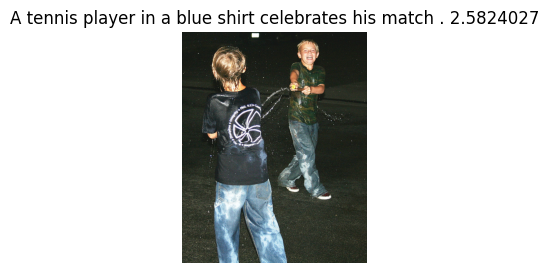

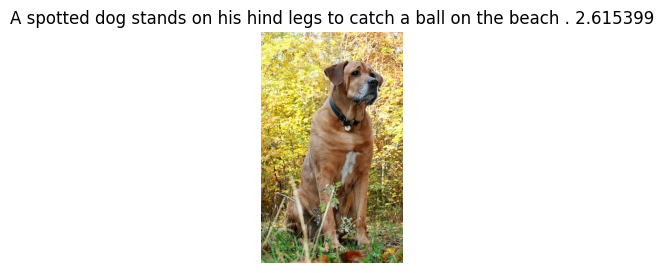

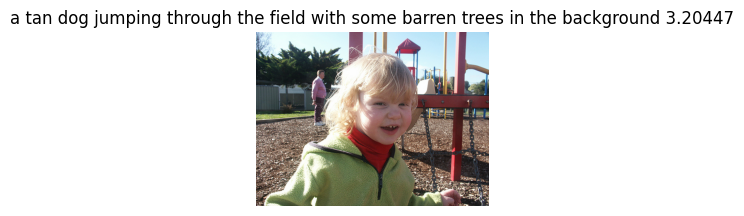

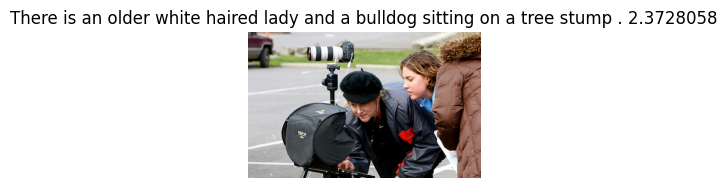

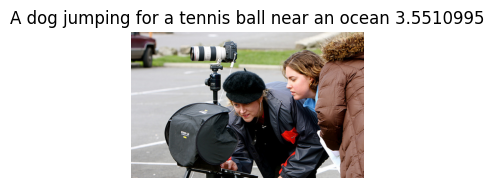

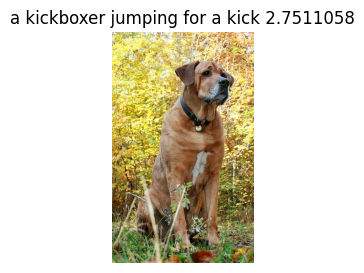

In [64]:
#random.seed(42)

texts = []
for i in range(0,10):
    texts.append(df_test.iloc[rd.randint(0, 499)]['query_text'])
for item in texts:
    get_image_from_text(item)

Модель правильно отрабатывает запрещенный контент.
Для текстовых запросов модель выдает изображения. Визуальный анализ результатов показал, что модель объективно выдает слабые результаты на тестовых данных при достаточно высокой предсказанной оценке экспертов.

предположительно для получения лучших результатов необходим более обширный датасет без явного дисбаланса классов.

## Выводы

**по итогам первичного анализа датасетов обнаружено**:
1. в данных отсутствуют пропуски.
2. для тренировки модели предоставлено 1000 изображений
3. для тестирования модели предоставлено 100 изображений
4. краудсорсинговая оценка - средняя доля подтвердивших соответствие изображения текстовому описанию составляет всего 7%. среднее количество участников краудсорсинговой оценки - 3 человека
5. экспертная оценка - средняя экспертная оценка не превышает 2

судя по всему мы имеем большой перекос в сторону несоответствия текстов изображениям


**итоги анализа изображений**:
- в датасете представлены изображения разного качества, наклона, пола, типа (фас, профиль и т.д.), тематики
- все изображения цветные
- изображения имеют разные размеры (потребуется приведение к единому формату)

**получение агрегированной оценки**:
для получения агрегированной оценки выбраны оценки экспертов.
среди оценок экспертов выбирается оценка, которую поставило большинство экспертов (т.е. 2 или 3). если все оценки разные, то такие данные удаляются. по итогу обработки оценок и слияния датасета с оценками с тестовым датасетом осталось 5696 записей из 5822)

Визуально подтверждается, что итоговая экспертная оценка вполне отображает соответствие изображения текстовому описанию.

**очистка тренировочного датасета от запрещенного контента**:
в тренировочном датасете 337 уникальных описаний, содержащих "десткие" слова

по итогам очистки тренировочного датасета от "дестких" описаний осталось 3888 записей.

**векторизация и объединение векторов изображений и текстов**:
для векторизации изображений применена натренированная модель ResNet18. по итогам векторизации изображений получен вектор размерностью (3888, 512)

для векторизации изображений применена натренированная модель ResNet18. по итогам векторизации изображений получен вектор размерностью (3888, 512)

по итогам объединения векторов изображений и векторов текстов получен вектор размерностью (3888, 1512)

**выбор метрики качества и обучение модели**:
В рамках этапа обучения рассмотрено 3 модели: Линейная регрессия, Логистическая регрессия и нейронная сеть.

Лучший результат получен у нейронной сети. Для оценки качества выбрана метрика RMSE. Метрика на валидации - 0,9

**тестирование модели**:
Модель правильно отрабатывает запрещенный контент.
Для текстовых запросов модель выдает изображения. Визуальный анализ результатов показал, что модель объективно выдает слабые результаты на тестовых данных при достаточно высокой предсказанной оценке экспертов.

предположительно для получения лучших результатов необходим более обширный датасет без явного дисбаланса классов.